In [32]:
!pip install librosa
import numpy as np
import matplotlib.pyplot as plt
import ldpc
import librosa
from scipy.io.wavfile import write
from scipy.signal import correlate


In [33]:
# All constants

SYMBOLS_PER_BLOCK = 4095
N_DFT = 2 * (SYMBOLS_PER_BLOCK + 1)
CYCLIC_PREFIX = N_DFT // 4
BLOCK_LENGTH = N_DFT + CYCLIC_PREFIX

SAMPLING_RATE = 48000

CHIRP_FACTOR = 0.01
CHIRP_LENGTH = BLOCK_LENGTH
CHIRP_LOW = 20
CHIRP_HIGH = 20000

NUMBER_OF_PILOT_BLOCKS = 8
NUMBER_OF_BLOCKS = 20

# Define QPSK mapping and modulation
MAPPING = {
    (0, 0): 1 + 1j,
    (0, 1): -1 + 1j,
    (1, 0): 1 - 1j,
    (1, 1): -1 - 1j,
}
MAPPING = {k: v / np.sqrt(2) for k, v in MAPPING.items()}
INV_MAPPING = {v: k for k, v in MAPPING.items()}
BITS_PER_SYMBOL = 2

# WIENER FILTER
SNR = 10

# LDPC SETTINGS
DECTYPE = 'sumprod2'
CODE = ldpc.code(z=81)


In [34]:
# Generate data bits
num_bits = BITS_PER_SYMBOL * SYMBOLS_PER_BLOCK * NUMBER_OF_BLOCKS
bits = np.random.default_rng(42).integers(0, 2, num_bits)
print(num_bits)

163800


In [35]:
# Encode LDPC
bits = np.concatenate((bits, np.zeros((-num_bits) % CODE.K)))
encoded_bitstream = np.array([])
for i in range(0, len(bits), CODE.K):
    encoded_bitstream = np.concatenate((encoded_bitstream, CODE.encode(bits[i:i + CODE.K])))
print(len(encoded_bitstream))

328536


In [36]:
# Turn bits to QPSK symbols
def qpsk_modulate(bits):
    bits = bits.reshape((-1, 2))
    symbols = np.array([MAPPING[tuple(b)] for b in bits])
    return symbols

qpsk_symbols = qpsk_modulate(encoded_bitstream)
post_padding = qpsk_modulate(np.zeros((-len(qpsk_symbols)) % SYMBOLS_PER_BLOCK * BITS_PER_SYMBOL))
qpsk_symbols = np.concatenate((qpsk_symbols, post_padding))

print(len(qpsk_symbols))

167895


In [37]:
# Go to time domain
ofdm_blocks = []

for i in range(len(qpsk_symbols) // SYMBOLS_PER_BLOCK):
    data = qpsk_symbols[i * SYMBOLS_PER_BLOCK: (i+1) * SYMBOLS_PER_BLOCK]
    freq = np.zeros(N_DFT, dtype=complex)
    freq[1:SYMBOLS_PER_BLOCK + 1] = data
    freq[-SYMBOLS_PER_BLOCK:] = np.conj(data[::-1])
    time = np.fft.ifft(freq)
    time = np.real(time)
    cyclic_prefix = time[-CYCLIC_PREFIX:]
    block_with_cp = np.concatenate([cyclic_prefix, time])
    ofdm_blocks.append(block_with_cp)

NUMBER_OF_BLOCKS_WITH_CODING = len(ofdm_blocks)
print(NUMBER_OF_BLOCKS_WITH_CODING)

41


In [38]:
# Do the above for pilot bits
pilot_bits = np.random.default_rng(69).integers(0, 2, BITS_PER_SYMBOL * SYMBOLS_PER_BLOCK * NUMBER_OF_PILOT_BLOCKS)
print(len(pilot_bits))

qpsk_pilot_symbols = qpsk_modulate(pilot_bits)
print(len(qpsk_pilot_symbols))

pilot_blocks = []
for i in range(NUMBER_OF_PILOT_BLOCKS):
    data = qpsk_pilot_symbols[i * SYMBOLS_PER_BLOCK: (i+1) * SYMBOLS_PER_BLOCK]
    freq = np.zeros(N_DFT, dtype=complex)
    freq[1:SYMBOLS_PER_BLOCK + 1] = data
    freq[-SYMBOLS_PER_BLOCK:] = np.conj(data[::-1])
    time = np.fft.ifft(freq)
    time = np.real(time)
    cyclic_prefix = time[-CYCLIC_PREFIX:]
    block_with_cp = np.concatenate([cyclic_prefix, time])
    pilot_blocks.append(block_with_cp)

65520
32760


In [39]:
# Chirps
def generate_chirp(length, fs, f0, f1):
    t = np.linspace(0, length / fs, length, endpoint=False)
    k = (f1 - f0) / (length / fs)
    return CHIRP_FACTOR * np.sin(2 * np.pi * (f0 * t + 0.5 * k * t**2))

start_chirp = generate_chirp(CHIRP_LENGTH, SAMPLING_RATE, CHIRP_LOW, CHIRP_HIGH)
end_chirp = generate_chirp(CHIRP_LENGTH, SAMPLING_RATE, CHIRP_HIGH, CHIRP_LOW)

542720


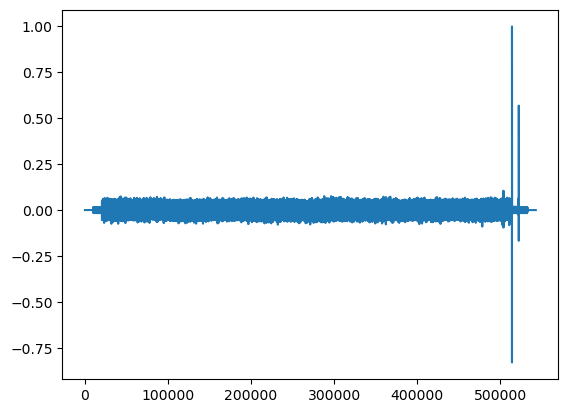

In [40]:
padding = np.zeros(BLOCK_LENGTH)

# New final signal with padding
signal = np.concatenate([
    padding,         # zero pad at the beginning
    start_chirp,     # start chirp
    *pilot_blocks,   # pilot blocks
    *ofdm_blocks,    # OFDM blocks
    end_chirp,       # end chirp
    padding          # zero pad at the end
])
print(len(signal))
signal_normalized = signal / np.max(np.abs(signal))
plt.plot(signal_normalized)
plt.show()
write("untitled.wav", SAMPLING_RATE, signal_normalized.astype(np.float32))

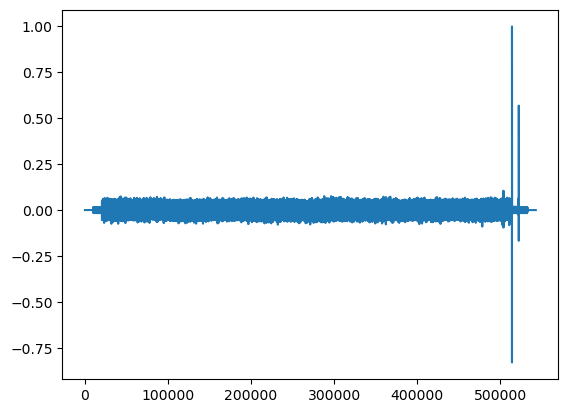

In [41]:
received_audio = "untitled.wav"
# received_audio = "Untitled.aifc"
received_signal, sr = librosa.load(received_audio, sr=SAMPLING_RATE, mono=True)
plt.plot(received_signal)
plt.show()

In [42]:
corr_start = correlate(received_signal, start_chirp, mode='valid')
start_index = np.argmax(np.abs(corr_start))

corr_end = correlate(received_signal, end_chirp, mode='valid')
end_index = np.argmax(np.abs(corr_end))

print(start_index, end_index)

# In the future we need to guess the expected length
expected_length = CHIRP_LENGTH + BLOCK_LENGTH * (NUMBER_OF_PILOT_BLOCKS + NUMBER_OF_BLOCKS_WITH_CODING)
print("Number of data samples:", (end_index - start_index))
print("Expected length:", expected_length)

10240 522240
Number of data samples: 512000
Expected length: 512000


512000


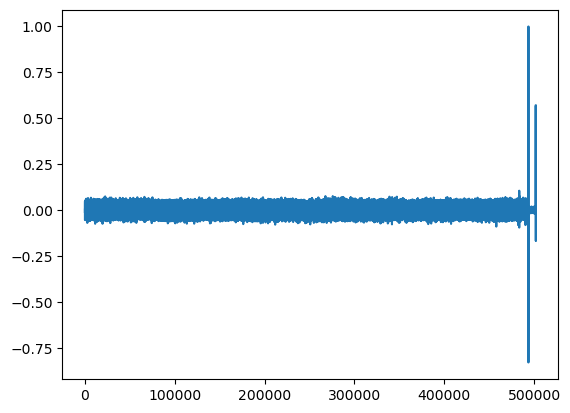

In [43]:
extracted_ofdm = received_signal[start_index:end_index]
sampling_ratio = expected_length / len(extracted_ofdm)
extracted_resampled = librosa.resample(extracted_ofdm, orig_sr=SAMPLING_RATE, target_sr=SAMPLING_RATE * sampling_ratio)
print(len(extracted_resampled))
extracted_resampled = extracted_resampled[CHIRP_LENGTH: CHIRP_LENGTH+expected_length]
plt.plot(extracted_resampled)
plt.show()

In [44]:
ofdm_blocks_time = extracted_resampled.reshape((NUMBER_OF_PILOT_BLOCKS + NUMBER_OF_BLOCKS_WITH_CODING, BLOCK_LENGTH))

# Remove cyclic prefix and apply FFT
ofdm_blocks_freq = []

for block in ofdm_blocks_time:
    block_no_cp = block[CYCLIC_PREFIX:]           # Remove CP → now length = N_DFT
    block_fft = np.fft.fft(block_no_cp)           # FFT → returns N_DFT complex values
    ofdm_blocks_freq.append(block_fft)

ofdm_blocks_freq = np.array(ofdm_blocks_freq)

demodulated_pilot_symbols = ofdm_blocks_freq[:NUMBER_OF_PILOT_BLOCKS, 1:SYMBOLS_PER_BLOCK + 1]
demodulated_symbols = ofdm_blocks_freq[NUMBER_OF_PILOT_BLOCKS:, 1:SYMBOLS_PER_BLOCK + 1]

# Get old symbols
qpsk_pilot_symbols = qpsk_pilot_symbols.reshape(demodulated_pilot_symbols.shape)
qpsk_symbols = qpsk_symbols.reshape(demodulated_symbols.shape)
print(qpsk_pilot_symbols.shape, qpsk_symbols.shape)

(8, 4095) (41, 4095)


In [45]:
estimated_channel_coefficients = np.mean(demodulated_pilot_symbols / qpsk_pilot_symbols, axis=0)
estimated_channel_coefficients = np.tile(estimated_channel_coefficients, (NUMBER_OF_BLOCKS_WITH_CODING, 1))
print(estimated_channel_coefficients.shape)

(41, 4095)


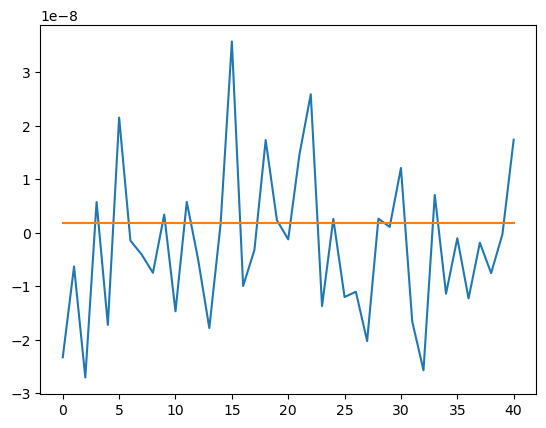

In [ ]:
# Real channel coefficients
channel_coefficients = demodulated_symbols / qpsk_symbols
plt.plot(np.angle(channel_coefficients[:,20]))
plt.plot(np.angle(estimated_channel_coefficients[:,20]))
plt.show()

In [47]:
# kernel = np.array([1/2,0,1/2])
# estimated_channel_coefficients = np.array([np.convolve(column, kernel, mode='same') for column in channel_coefficients.T]).T
# print(estimated_channel_coefficients[:9,20])
# estimated_channel_coefficients = np.mean(channel_coefficients, axis=0)
estimated_symbols = demodulated_symbols / estimated_channel_coefficients
estimated_symbols = demodulated_symbols * np.conjugate(estimated_channel_coefficients)/(np.abs(estimated_channel_coefficients)**2 + 1/SNR)

Correctness: 1.0


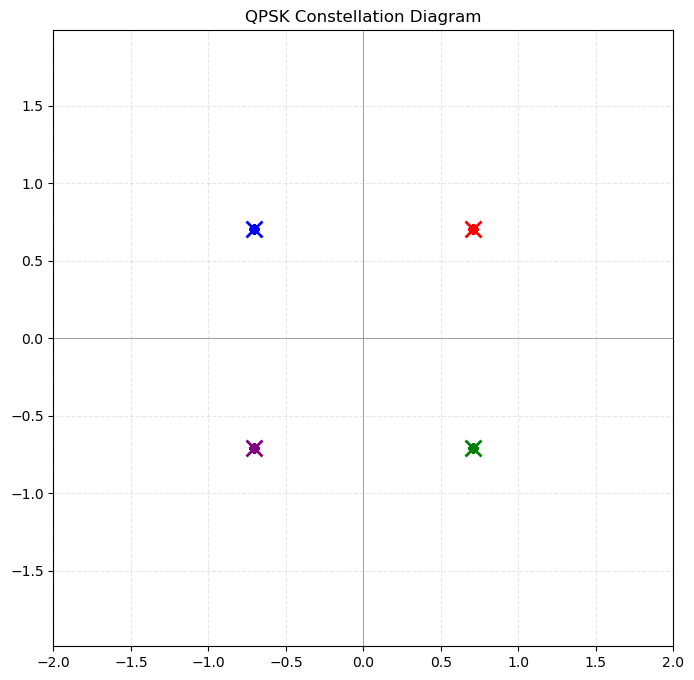

In [48]:
colors = ['red', 'blue', 'green', 'purple']

constellation_points = list(MAPPING.values())

tx = qpsk_symbols.flatten()
rx = estimated_symbols.flatten()
rx = rx / np.sqrt(np.mean(np.abs(rx)**2))

# rx = np.reshape(rx, (-1, SYMBOLS_PER_BLOCK))[:,SYMBOLS_PER_BLOCK*9//10:SYMBOLS_PER_BLOCK].flatten()
# tx = np.reshape(tx, (-1, SYMBOLS_PER_BLOCK))[:,SYMBOLS_PER_BLOCK*9//10:SYMBOLS_PER_BLOCK].flatten()

# Assign each transmitted symbol a color index based on its closest ideal point
def find_closest_constellation(symbol, constellation):
    distances = [np.abs(symbol - c) for c in constellation]
    return np.argmin(distances)

# Get color labels based on transmitted symbols' closest constellation points
color_labels = np.array([find_closest_constellation(sym, constellation_points) for sym in tx])

# Plot received points colored by intended QPSK cluster
plt.figure(figsize=(8, 8))
for i in range(4):
    plt.scatter(rx.real[color_labels == i], rx.imag[color_labels == i], color=colors[i], label=f'Cluster {i}', alpha=0.1)

# Plot ideal constellation points in matching color
for i, point in enumerate(constellation_points):
    plt.plot(point.real, point.imag, 'x', color=colors[i], markersize=12, mew=2, label=f'QPSK {i}')

# Formatting
plt.axhline(0, color='gray', lw=0.5)
plt.axvline(0, color='gray', lw=0.5)
plt.grid(True, linestyle='--', alpha=0.3)
plt.axis('equal')
plt.title("QPSK Constellation Diagram")

decoded_symbols = np.array([find_closest_constellation(sym, constellation_points) for sym in rx])
original_symbols = np.array([find_closest_constellation(sym, constellation_points) for sym in tx])
print("Correctness:", np.sum(decoded_symbols == original_symbols) / len(original_symbols))

plt.xlim(-2,2)
plt.ylim(-2,2)
plt.show()


In [49]:
# QPSK only

decoded_bits = ""
for sym in decoded_symbols:
    if sym == 0: decoded_bits += "00"
    elif sym == 1: decoded_bits += "01"
    elif sym == 2: decoded_bits += "10"
    elif sym == 3: decoded_bits += "11"
    else: exit("symbol error")
decoded_bits = np.array([int(bit) for bit in decoded_bits])
decoded_bits = decoded_bits[:len(encoded_bitstream)]

print("Bit error rate pre-LDPC:", np.sum(decoded_bits != encoded_bitstream) / len(encoded_bitstream))

Bit error rate pre-LDPC: 0.0


In [55]:
# QPSK only

LLR = np.array([[sym.real, sym.imag] for sym in rx]).flatten()

bitstream = np.array([])
for i in range(0, len(LLR)//CODE.N, CODE.N):
    bitstream = np.concatenate((bitstream, CODE.decode(LLR[i:i + CODE.N], DECTYPE)[0][:CODE.K]))
bitstream = np.where(bitstream > 0, 0, 1)
print("Bit error rate after LDPC:", np.sum(bitstream != bits) / len(bits))

OSError: dlopen(c_ldpc.so, 0x0006): tried: '/Users/benlou/opt/anaconda3/lib/c_ldpc.so' (no such file), '/Users/benlou/opt/anaconda3/lib/c_ldpc.so' (no such file), '/Users/benlou/opt/anaconda3/lib/python3.8/lib-dynload/../../c_ldpc.so' (no such file), '/Users/benlou/opt/anaconda3/lib/c_ldpc.so' (no such file), '/Users/benlou/opt/anaconda3/bin/../lib/c_ldpc.so' (no such file), 'c_ldpc.so' (mach-o file, but is an incompatible architecture (have 'arm64', need 'x86_64')), '/usr/local/lib/c_ldpc.so' (no such file), '/usr/lib/c_ldpc.so' (no such file), '/Users/benlou/Documents/GitHub/audio_modem/c_ldpc.so' (mach-o file, but is an incompatible architecture (have 'arm64', need 'x86_64')), '/usr/local/lib/c_ldpc.so' (no such file), '/usr/lib/c_ldpc.so' (no such file)